# A Real World SVM Model: Boxing Punch Classification
To this point we've really looked at some of our own work using SVMs for prediction in professional major league sports, but I want to pick up the research end and I want to do that with wearables in particular. A lot of our features have been nice and cleaned and easy to understand, but wearables are producing huge noisy data streams which are really difficult to interpret at times. For instance, this little IMU device can capture acceleration in three dimensions, gyroscope data, temperature, light, pressure, and more, and it costs about $100 and lasts for a day. Even more, it can capture some of these measurements at a rate of almost 1,000 times per second. That's an incredible amount of data.

So what happens when we strap a few of these to an athelete, and what can we do with that?

A great place to start this investigation is with some replication wortk. Matthew Worsey et al. (2020) described an approach to 
automatic classification of boxing punches through motion sensors and machine learning. In this work, they trained a model on a single athelete who wore sensors at each wrist as well as one in the middle of the upper back - at the T3 vertebrae. Each sensor captured three dimensions of spatial position as well as rotation and acceleration. To collect training data, they classified  250 punches the athelete threw: a left jab, hook, and uppercut, and a right cross and right uppercut. Following good practices they captured equal sized numbers of each punch type (50 each).

After training a model, they then evaluated it on a hold-out dataset of 82 punches across the five categories, all done by the same athelete.
They built several predictive models to see if they could predict from the sensor data the kind of punch thrown, and one of the models was an
SVM model. They've done the hard work of collecting the data for us, so why don't we dig in and see if we can build our own models.

-----
Worsey, Matthew T.O.; Espinosa, Hugo G.; Shepherd, Jonathan B.; Thiel, David V. 2020. "An Evaluation of Wearable Inertial Sensor Configuration and Supervised Machine Learning Models for Automatic Punch Classification in Boxing" IoT 1, no. 2: 360-381. https://doi.org/10.3390/iot1020021

In [1]:
# The data the authors provided have over 100 different features setup for us. Each feature represents a set of summary 
# statistics from the the underlying sensor data, but Matthew was kind enough to send me the processed data so we could
# use it. But he did send me the raw data as well, and I just want to take a moment to explain what it looks like.
import pandas as pd
import zipfile

filename="assets/gust_boxing.zip"
df_raw=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Left wrist")
df_raw.head()

,Sample_rate (Hz),Accel_x (g),Accel_y (g),Accel_z (g),Gyro_x (deg/s),Gyro_y (deg/s,Gyro_z (deg/s,Roll (rad),Pitch (rad),Yaw (rad)
0,250.0,0.902832,-0.353027,-0.229492,-1.341463,-2.865854,0.670732,-0.010407,-0.016146,-0.006142
1,NaN,0.902832,-0.356445,-0.238770,-1.646341,-2.926829,0.548780,-0.020827,-0.032318,-0.012059
2,NaN,0.897949,-0.353027,-0.235352,-1.524390,-2.865854,0.792683,-0.028291,-0.047797,-0.022268
3,NaN,0.900391,-0.350098,-0.231934,-1.646341,-2.926829,1.097561,-0.035675,-0.063366,-0.032244
4,NaN,0.900879,-0.350098,-0.233398,-1.524390,-2.926829,0.853659,-0.043032,-0.078995,-0.041999


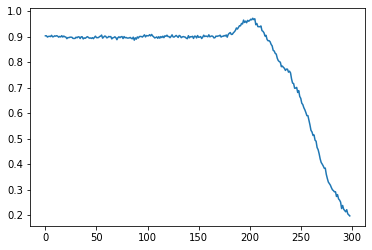

In [2]:
# If we look we can see the sampling rate was at 250 times a second, and we have the acceleration and rotation in
# the X, Y, and Z space. They determine when a punch connected based on the impact of the glove sensor. Then, they
# partitioned the data 0.6 seconds before and after this point. At 250 Hz that means there were 300 sensor observations
# for each sensor for each punch.

# Let's just take a look at the first 300 observations for the X axis acceleration on the left wrist here:
df_raw["Accel_x (g)"].iloc[0:299].plot();

In [3]:
# So, how would we actually feed this into an SVM? Well, the approach they took was to generate some summary
# statistics which describe the distribution you see. For instance:
features={}
features["Ax_mean"]=df_raw["Accel_x (g)"].iloc[0:299].mean()
features["Ax_std"]=df_raw["Accel_x (g)"].iloc[0:299].std()
features["Ax_min"]=df_raw["Accel_x (g)"].iloc[0:299].min()
features["Ax_kurtosis"]=df_raw["Accel_x (g)"].iloc[0:299].kurtosis()
features["Ax_skew"]=df_raw["Accel_x (g)"].iloc[0:299].skew()
features

{'Ax_mean': 0.8082214151337793,
 'Ax_std': 0.19795360897835151,
 'Ax_min': 0.19677734375,
 'Ax_kurtosis': 2.4390689491515682,
 'Ax_skew': -1.9416143269619313}

Ok, so that's the approach Worsey and team took to take this very rapid fine-grained sensor data and turn it into momentary features for classifying boxing punches. But, there lots of different ways one could do this. So here's a bit of thought experiment, imagine you were doing this study and you could put sensors anywhere on the boxer's body. Now, where would you put them, and how might you generate features from the underlying sensor data?

In [4]:
# With a bit of a discussion of the data done, let's give it a go with building some SVMs. Let's bring in our 
# typical data processing and svm libraries
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_validate

# Now we will read in the boxing data. We'll start with just one sensor, the sensor
# placed on the T3 vertebrae (upper back). The authors have separated the training
# and testing datasets for us so this is straightforward
import zipfile
filename="assets/gust_boxing.zip"
df_train=pd.read_csv(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Training_features_T3_sensor.csv"))
df_test=pd.read_csv(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Evaluation_features_T3_sensor.csv"))

In [8]:
df_train['class'].value_counts()

Right_cross       50
Right_uppercut    50
Left_jab          50
Left_hook         50
Left_uppercut     50
Name: class, dtype: int64

In [9]:
# In the datafiles the class column is our y predictors
X_train=df_train[df_train.columns.drop("class")]
y_train=df_train["class"]
X_test=df_test[df_test.columns.drop("class")]
y_test=df_test["class"]

# Now we can set our model and use cross validation to see how accurate it is
clf=svm.SVC(kernel='linear')
results=cross_validate(clf,X_train,y_train,cv=5,scoring='accuracy')

# And we'll print the results of our model accuracy
print(f"The cv score results are {results['test_score']}")
print(f"The average cv score results are {np.mean(results['test_score'])} with a standard deviation of {np.std(results['test_score'])}")

The cv score results are [0.86 0.84 0.96 0.96 0.96]
The average cv score results are 0.916 with a standard deviation of 0.05425863986500214


Alright! That looks like a pretty good classifier, sitting around 90% accurate! Let's take a look at how well it works on the holdout test set we were provided.

In [10]:
# First we need to fit the model, remember that here we are not going to use
# cross validation for fitting the model, we are going to fit the model with all
# of our data because we have a dedicated hold out set and this should give us
# the strongest accuracy
clf.fit(X_train,y_train)

# Now lets compare the accuracy between our predicted outcomes and our known
# outcomes
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(X_test),y_test)

0.6707317073170732

So that's a bit deflating - the accuracy is significantlly lower than the accuracy we had previously seen. But don't get too worried yet, we need to talk about what accuracy
really means. In this context, accuracy is whether the exact label is predicted as
intended. As you increase the number of classes - in this case to five - you would expect
that there would be a hard time just getting the predicted value correct by chance. For
instance, if just guessed randomly at the outcome of two teams playing against one another, you would expect to be right roughly half the time - 50%. But now that we have
5 classes to guess from, your chance of being correct - assumiung each class happened with equal frequency - is 20%. So accuracy is a bit of a misleading metric, and is one which is rarely used for descision making with machine learning models.

Instead, let's look at a new method to understand our model: the confusion matrix.

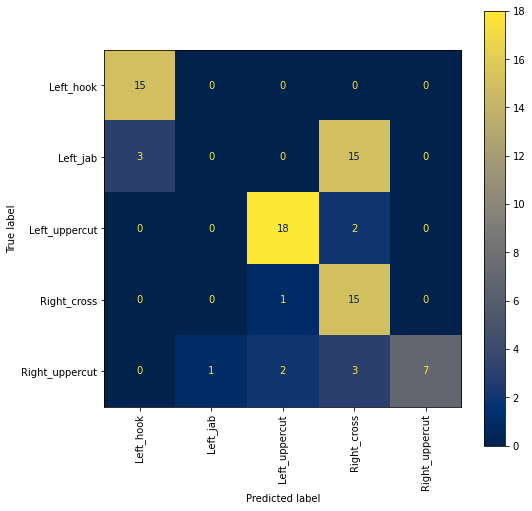

In [11]:
# Scikit-Learn has a handy option to plot a confusion matrix. In this plot, which
# is a heatmap, the True labels (correct values) are plotted against the Predicted
# labels (those generated by our classifier).
from sklearn.metrics import plot_confusion_matrix

# We have a lot of different parameters we can submit to this function. The first
# three are core, and include the classifier we want to use, followed by the data
# we want to run through the classifier. In this case, that's our holdout test
# set, first the features X_test and followed by the class labels y_test. Then
# I'm going to tell sklearn what the class labels means, how to display them, and
# what coloring I want to be shown.
matrix=plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical', cmap='cividis')

# And I'm just going to tweak the size of the figure so it's easier to see
matrix.figure_.set_size_inches(8,8)

Take a moment to study the confusion matrix. The y axis on the left are the labels that come from
our data, called the true labels. Along the bottom axis are the labels which our classifier predicted.
The color of each cell corresponds to the number of instances which intersect with the labeled data
and our classifier prediction. Each cell is color coded, dark blue means there were no instances at
the intersection, and bright yellow means there were a lot. A perfect classifier with an accuracy of
100% would show a bright yellow diagonal line on the confusion matrix, showing perfect alignment
between observed and predicted classes.

We can use that knowledge to quickly make sense of the confusion matrix - several of the bright yellow
squares fall along the diagonal, and we can see that our classifier is good at predicting right 
uppercuts as well as left jobs and hooks. If we look at the bottom right hand corner we see that the
right uppercut is not well predicted by this model. Reading the bottom row, we can see that there were
13 instances of a right uppercut (just sum all the numbers), but that only 7 of them were correctly
classified, and that our classifier predicted a number of them to be left jabs, uppercuts, or even a right
cross.

And let's talk about that left jab for a moment - if you find the row labeled with a left jab you'll
notice that our model made no correct predictions for this class! Instead, the model predicted the
vast majority of them as right crosses, and a few of them as left hooks. This is a great example of
why the confusion matrix is neccessary to understand how your model is making errors -- this model is
pretty good with correctly predicting many different punches, but is unable to make an even chance
prediction for the left jab, and severely overpredicts whether a punch will be a right cross.

I think this data does a great job of demonstrating why you can't just take accuracy as a metric and think it tells the whole story. Instead, the confusion matrix gives you a much better understanding of where things are going wrong. This can be helpful both in estimating the performance of the model in the real world -- in this case that left jab just isn't going to show up -- and in iterating on your features.

Of course, in this data I've intentionally just looked at one sensor, the one on the back at T3. It seems natural to me that including data with respect to the gloves themselves would clean up this classification problem.


In [ ]:
# But let's end off this lecture with a little more discussion of metrics. I think inspection of that
# confusion matrix is important for you as the sports data scientist, but sometimes you want a way
# to more simply describe the data. The first metric we can look at the precision of the classifier. 
# In a multiclass predictor such as this, this is the ratio of the true positives divided by the
# combined number of true and false positives for that class. For instance, in this model we never
# make a prediction of a right upper cut and are wrong. So 7/(7+0)=1. However, we regularly predict
# the right cross and are wrong, so there the precision is low (15/15+(3+15+2))
from sklearn.metrics import precision_score
df_precision=pd.DataFrame([precision_score(y_test,clf.predict(X_test),average=None)],columns=sorted(y_test.unique()))
df_precision

In [ ]:
# Recall, on the other hand, is the number of true positives divided by the true positives and
# false *negatives*. This score gets smaller when you incorrectly predict that a given was a given 
# class (a false negative). In this case, the right cross recall is much better (93%), since 
# we very rarely will see a right cross punch and predict it to be something else (only one
# example here where we predicted a left uppercut and it ended up being a right cross)
from sklearn.metrics import recall_score
df_recall=pd.DataFrame([recall_score(y_test,clf.predict(X_test),average=None)],columns=sorted(y_test.unique()))
df_recall

All right, so this wraps up our introduction to Support Vector Machines. We saw how, when you are using a binary class prediction like fastball or changeup and only two features such as speed and spin we can visualize the descision boundary - the street - as a straight line with a linear SVM. The modeling technique gets its name from the datapoints which constrain this line, and they are called the support vectors. We don't have to have to cast this as a linear problem though, and can build a polynomial kernel and constrain it in different ways to learn a better fitting descision boundary.

More generally we call these boundaries hyperplanes, and we can apply them in n-dimensions and use many different features. We also don't have to constrain our model to binary classification, as you saw in this lecture where we tackled a five class prediction. Finally, we dove in a bit more on how to evaluate how good a model actually is, including understanding the confusion matrix as a sensemaking device, and the precision and recall statistics as different ways to summarize aspects of the confusion matrix.